In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb

In [170]:
df = pd.read_csv("C:/work/Kaggle/agro/data/train_dataset_train.csv")
dft = pd.read_csv("C:/work/Kaggle/agro/data/test_dataset_test.csv")

df.shape, dft.shape

((4830, 74), (2071, 73))

In [171]:
def get_coord_feas(s):
    v = json.loads(s)
    t = 1 if 'coordinates' in v.keys() else 0
    x = v['coordinates'] if 'coordinates' in v.keys() else [w['coordinates'][0]
                                                            for w in v['geometries'] if w['type']=='Polygon']
    z = [b for a in x for b in a]
    if type(z[0][0]) is list:
        z = [b for a in z for b in a]
        
    zx = [a[0] for a in z]
    zy = [a[1] for a in z]
    dx = (max(zx) - min(zx))
    dy = 2*(max(zy) - min(zy))
    d = np.sqrt(dx*dx + dy*dy)
    
    n = len(zx)
            
    return {'X':sum(zx)/n, 'Y':sum(zy)/n, 'D':d, 'sin':dy/d, 'len':n, 'type':t}

def add_feas(df):
    Z = df['.geo'].map(lambda v: get_coord_feas(v))
    df['X'] = Z.map(lambda v: v['X'])
    df['Y'] = Z.map(lambda v: v['Y'])
    df['XpY'] = df['X'] + df['Y']
    df['XmY'] = df['X'] - df['Y']
    df['Xp2Y'] = df['X'] + 2*df['Y']
    df['Xm2Y'] = df['X'] - 2*df['Y']
    df['size'] = Z.map(lambda v: v['D'])
    df['angle'] = Z.map(lambda v: v['sin'])
    df['c_len'] = Z.map(lambda v: v['len'])
    df['c_type'] = Z.map(lambda v: v['type'])
    df['ext'] = 100000*df['size']*df['size'] / df['area']

    
add_feas(df)
add_feas(dft)
df

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,Y,XpY,XmY,Xp2Y,Xm2Y,size,angle,c_len,c_type,ext
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,51.412815,93.913118,-8.912513,145.325933,-60.325328,0.021183,0.389150,36,1,2.243563
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,56.606045,106.871653,-6.340437,163.477698,-62.946482,0.026451,0.675479,134,1,1.554754
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,53.837187,91.840417,-15.833956,145.677604,-69.671142,0.016500,0.745071,20,1,0.972273
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,...,55.935536,100.663245,-11.207827,156.598782,-67.143364,0.017946,0.769360,16,1,1.695082
4,3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,...,52.907252,87.690785,-18.123718,140.598037,-71.030970,0.018536,0.753283,33,1,1.041174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,3772,74,0.028770,0.038282,0.255329,0.148166,0.225421,0.479483,0.071684,0.016856,...,50.899595,91.805634,-9.993556,142.705228,-60.893150,0.026831,0.891493,52,1,0.972877
4826,5191,109,0.035939,0.030722,0.033869,0.029646,0.318387,0.247905,0.265180,0.286298,...,51.804439,91.818179,-11.790700,143.622618,-63.595139,0.033023,0.944493,92,1,1.000468
4827,5226,58,0.191255,0.063581,0.140111,0.323984,0.000000,0.005056,0.092693,0.399439,...,53.193459,91.777791,-14.609127,144.971250,-67.802587,0.025016,0.814600,46,1,1.078984
4828,5390,14,0.291399,0.221428,0.007247,0.055074,0.057781,0.187749,0.112403,0.183555,...,55.183574,108.502694,-1.864453,163.686268,-57.048027,0.019994,0.246009,13,1,2.855318


In [168]:
df.columns

Index(['id', 'area', 'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12', '.geo',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',


In [13]:
df.loc[df['c_type']==0,'crop'].value_counts()

1    3
6    2
5    1
0    1
2    1
4    1
3    1
Name: crop, dtype: int64

In [137]:
cols = ['area', 'X', 'Y', 'XpY', 'XmY', 'c_len', 'c_type'] + [v for v in df.columns.sort_values() if v[:2]=='nd']

X = df[cols].copy()
Xt = dft[cols]
Y = df['crop']
X

,area,X,Y,XpY,XmY,c_len,c_type,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,...,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27
0,20,42.500303,51.412815,93.913118,-8.912513,36,1,0.187150,0.072846,0.262300,...,0.727516,0.000000,0.754859,0.000000,0.030883,0.000000,0.658016,0.126832,0.034858,0.614770
1,45,50.265608,56.606045,106.871653,-6.340437,134,1,0.245285,0.332928,0.349133,...,0.666918,0.089721,0.706226,0.184231,0.062582,0.618475,0.601685,0.174914,0.000000,0.179612
2,28,38.003231,53.837187,91.840417,-15.833956,20,1,0.006391,0.013679,0.000000,...,0.321827,0.411168,0.000000,0.357296,0.045370,0.172080,0.000000,0.090607,0.000000,0.054127
3,19,44.727709,55.935536,100.663245,-11.207827,16,1,0.293425,0.105976,0.318047,...,0.000000,0.055983,0.152193,0.060656,0.352723,0.379196,0.327025,0.073492,0.061776,0.378900
4,33,34.783534,52.907252,87.690785,-18.123718,33,1,0.027983,0.130885,0.117227,...,0.833694,0.611108,0.772962,0.000000,0.080592,0.000000,0.055220,0.157676,0.022251,0.012048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,74,40.906039,50.899595,91.805634,-9.993556,52,1,0.066154,0.028770,0.000000,...,0.683847,0.379482,0.700605,0.645532,0.000000,0.059090,0.631144,0.042483,0.118901,0.022464
4826,109,40.013739,51.804439,91.818179,-11.790700,92,1,0.243867,0.035939,0.013403,...,0.792938,0.800815,0.634428,0.783913,0.093728,0.000000,0.776900,0.055721,0.057945,0.044182
4827,58,38.584332,53.193459,91.777791,-14.609127,46,1,0.090026,0.191255,0.019897,...,0.627561,0.740523,0.781434,0.783490,0.006700,0.132444,0.000000,0.007225,0.669367,0.145505
4828,14,53.319120,55.183574,108.502694,-1.864453,13,1,0.301663,0.291399,0.295089,...,0.133080,0.235802,0.000000,0.079623,0.049245,0.506127,0.528256,0.031836,0.000000,0.453151


<AxesSubplot:>

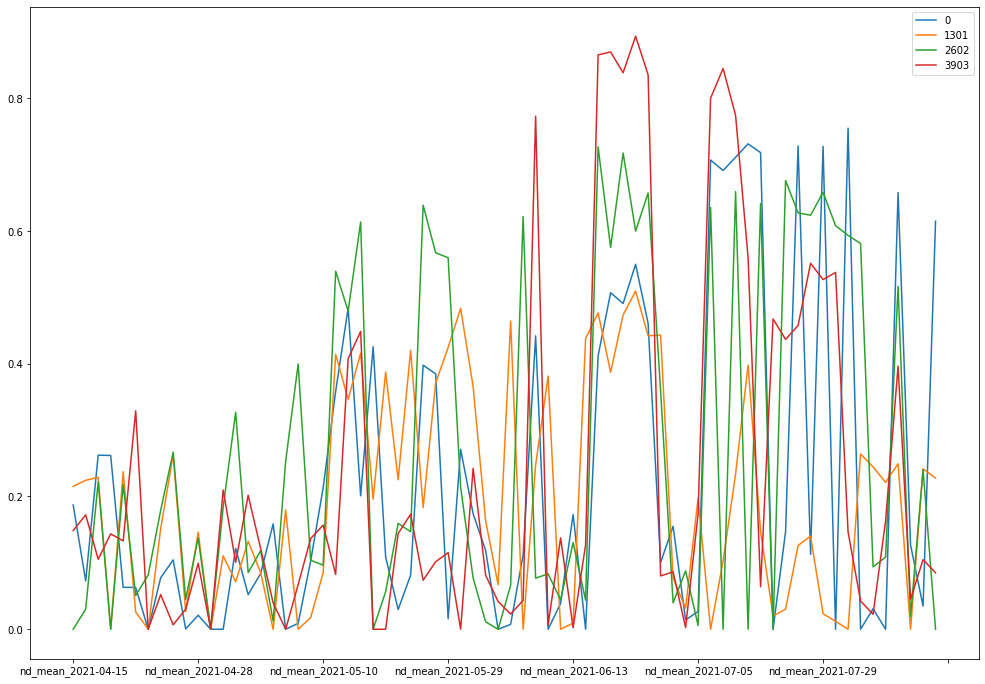

In [80]:
X.iloc[::1301,7:].T.plot(figsize=(17,12))

<AxesSubplot:>

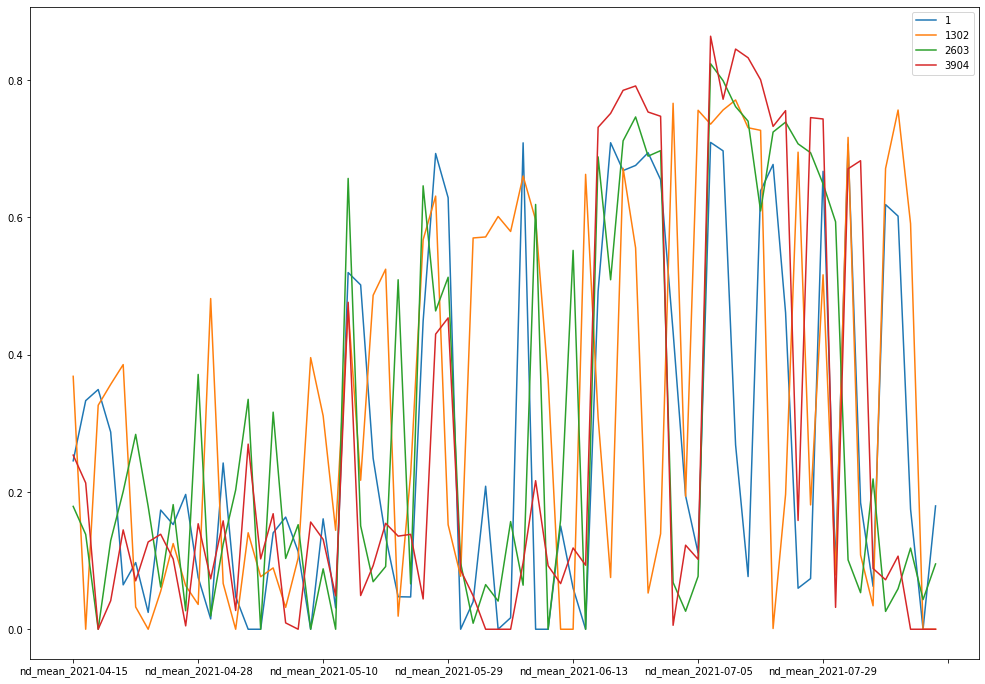

In [81]:
X.iloc[1::1301,7:].T.plot(figsize=(17,12))

<AxesSubplot:>

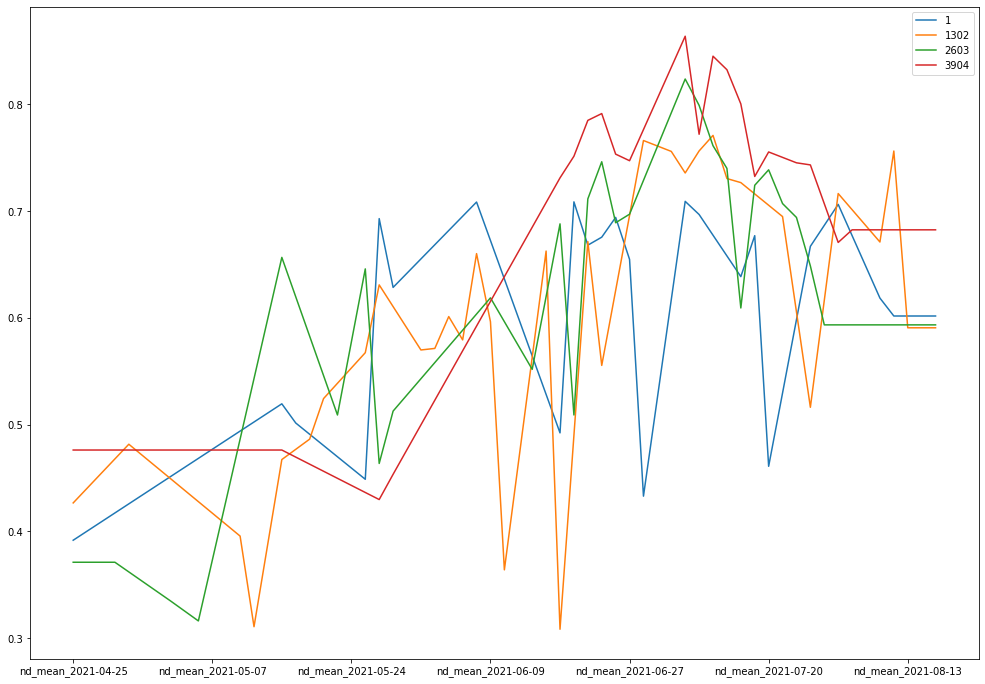

In [124]:
Z.T.iloc[1::1301,7:].T.plot(figsize=(17,12))

0
1
2
3
4
0.9738129054859058


<AxesSubplot:>

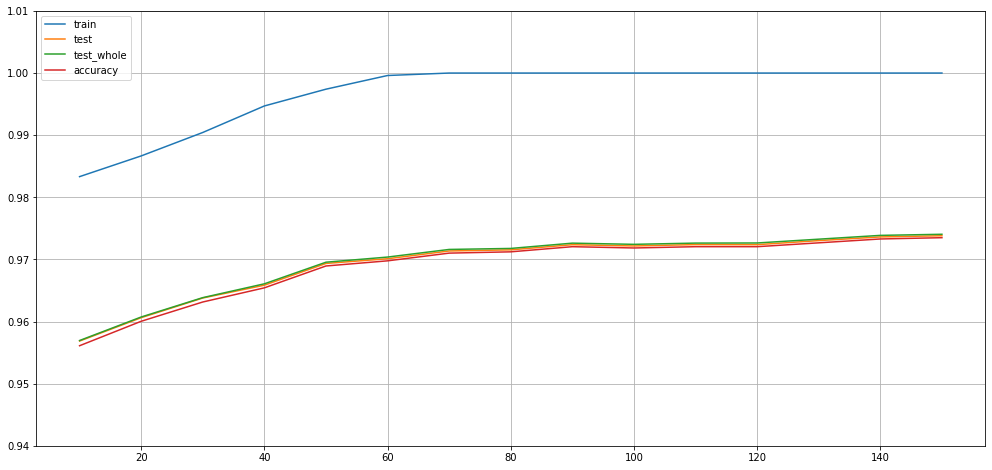

In [133]:
def calc_crossval_pred(X,Y,params):
    bst = xgb.XGBClassifier(**params)
    #nt = np.arange(10,bst.get_params()['n_estimators']+1,10).astype(int)
    #nt = list(range(10,bst.get_params()['n_estimators']+1,10))
    nt = list(range(10,params['n_estimators']+1,10))
    num_classes = int(Y.max()+1)
    #print(num_classes)
    n_splits=5
    scores = np.zeros((2,n_splits,len(nt)))#nt.shape[0]))
    preds = np.zeros((len(nt),X.shape[0]))
    probs = np.zeros((len(nt),X.shape[0],num_classes))

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    for i_fold, (train, test) in enumerate(kf.split(X)):
        print(i_fold)
        X_train = X.iloc[train]
        y_train = Y.iloc[train]
        X_test = X.iloc[test]
        y_test = Y.iloc[test]

        bst.fit(X_train, y_train)
        
        for i_sample, (x, y) in enumerate([(X_train,y_train), (X_test,y_test)]):
            for i,n_trees in enumerate(nt):
                #print(n_trees)
                p = bst.predict(x,iteration_range=(0,n_trees))
                scores[i_sample,i_fold,i] = recall_score(y, p, average="macro", zero_division=0)
                
                if i_sample==1:
                    preds[i,test] = p
                    probs[i,test] = bst.predict_proba(x,iteration_range=(0,n_trees))


    curve = pd.DataFrame(scores.mean(axis=1)).T
    curve.columns = ['train', 'test']
    curve['test_whole'] = [recall_score(Y, p, average="macro", zero_division=0) for p in preds]
    curve['accuracy'] = [(Y==p).sum()/Y.shape[0] for p in preds]
    curve.index = nt
    return {'params':params, 'curve':curve, 'scores':scores, 'preds':preds, 'probs':probs, 'max_score':curve['test'].max(),
           'feas':X.columns, 'Y':Y}

#res = []
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':150, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9711966539155983


<AxesSubplot:>

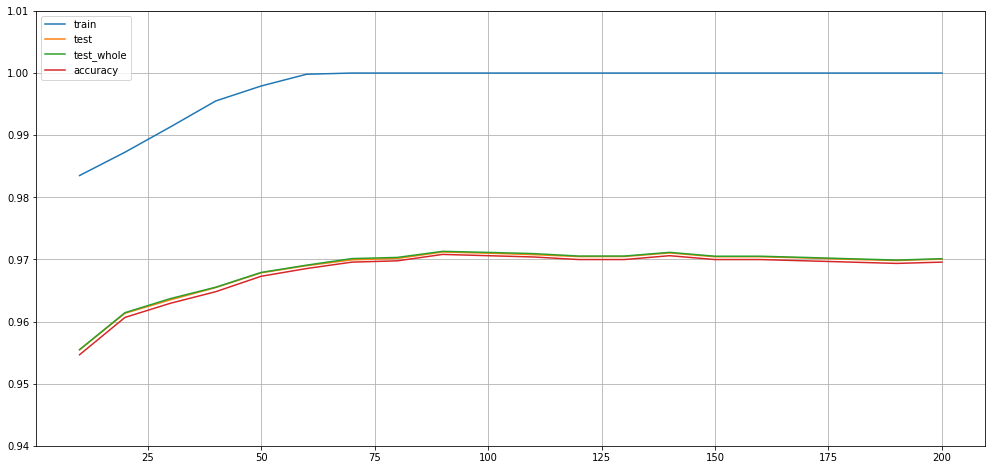

In [141]:
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9734066022033208


<AxesSubplot:>

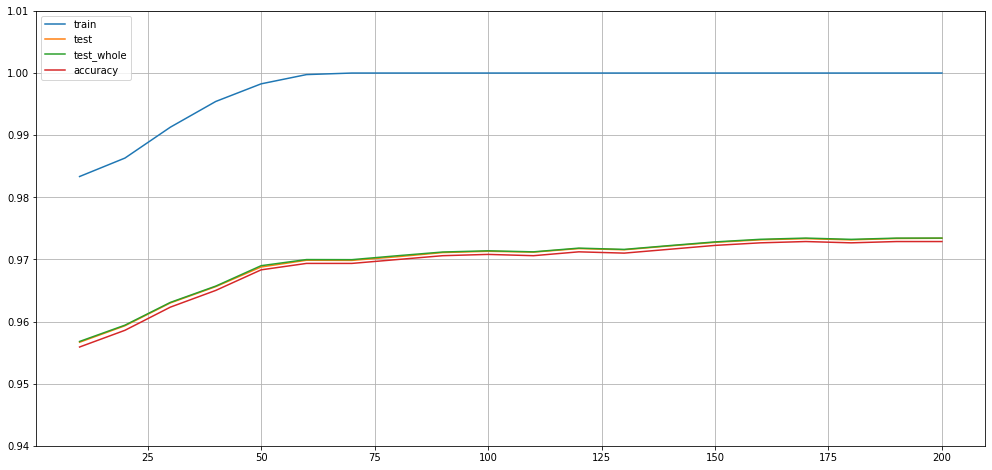

In [144]:
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.97172588672811


<AxesSubplot:>

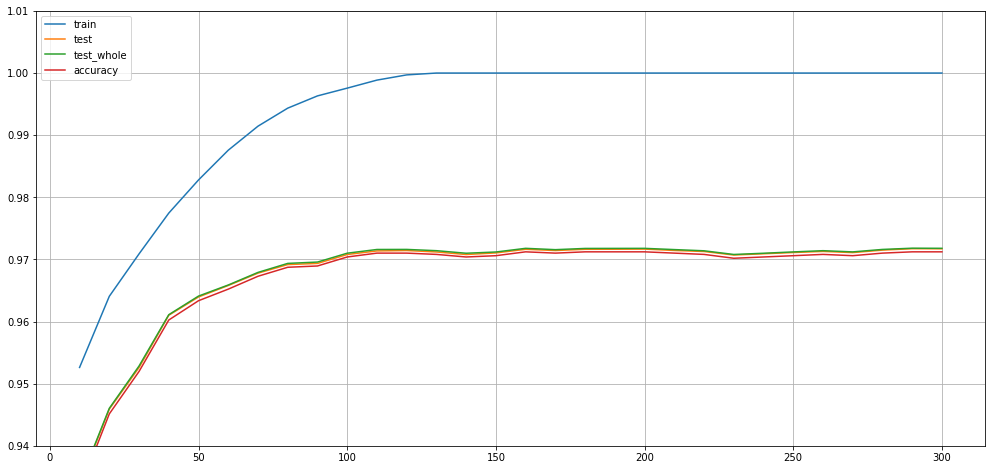

In [145]:
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.7, 'num_parallel_tree':7,
                                  'reg_lambda':0.1, 'n_estimators':300, 'max_depth':4, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9726947199911257
Wall time: 29min 24s


<AxesSubplot:>

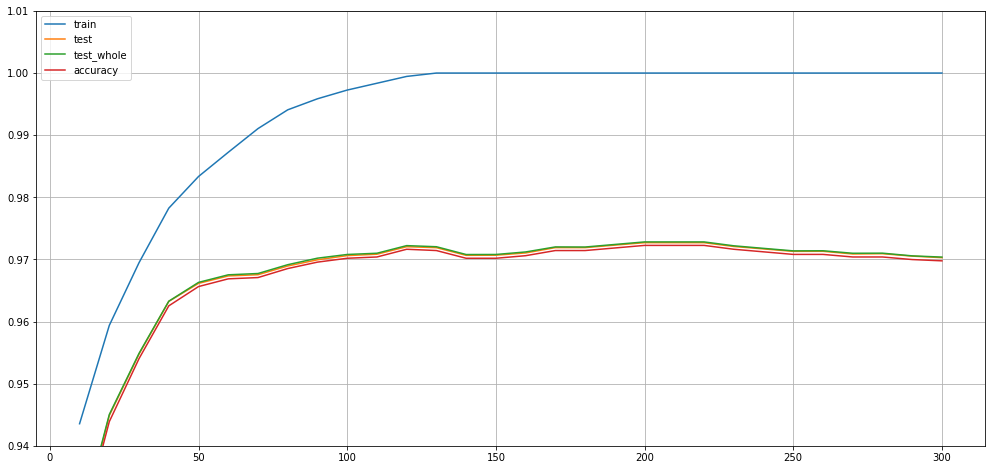

In [146]:
%%time

res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.6, 'num_parallel_tree':8,
                                  'reg_lambda':0.1, 'n_estimators':300, 'max_depth':3, 'learning_rate':0.15, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9734762343917367
Wall time: 24min 59s


<AxesSubplot:>

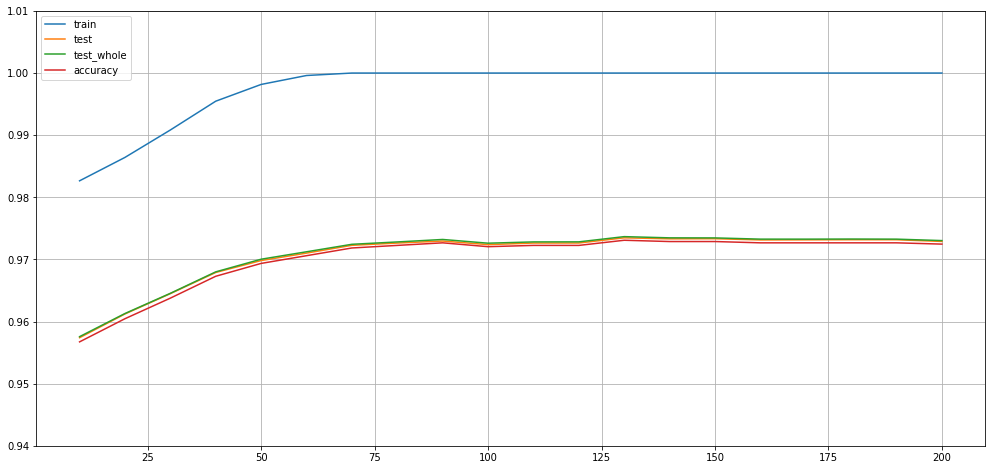

In [156]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                  'reg_lambda':0.5, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.974509183384253
Wall time: 34min 2s


<AxesSubplot:>

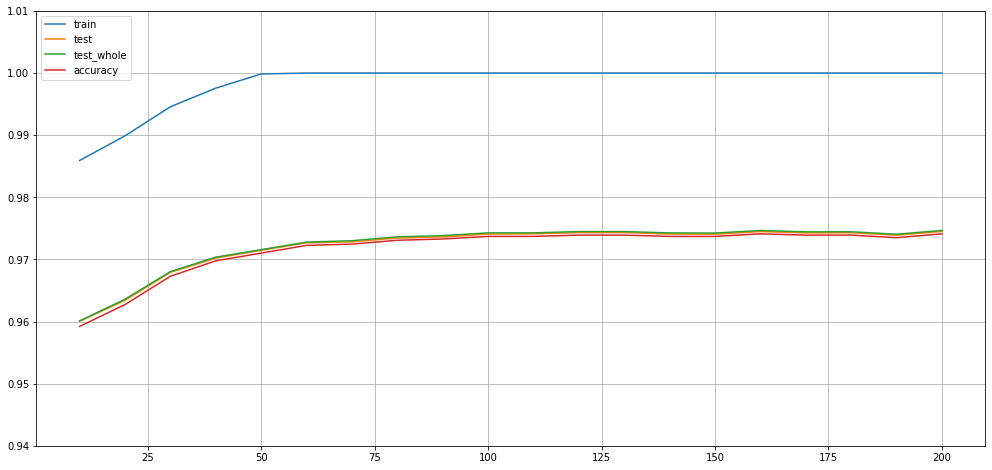

In [162]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                                  'reg_lambda':0.4, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.12, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9734451990889811
Wall time: 37min 10s


<AxesSubplot:>

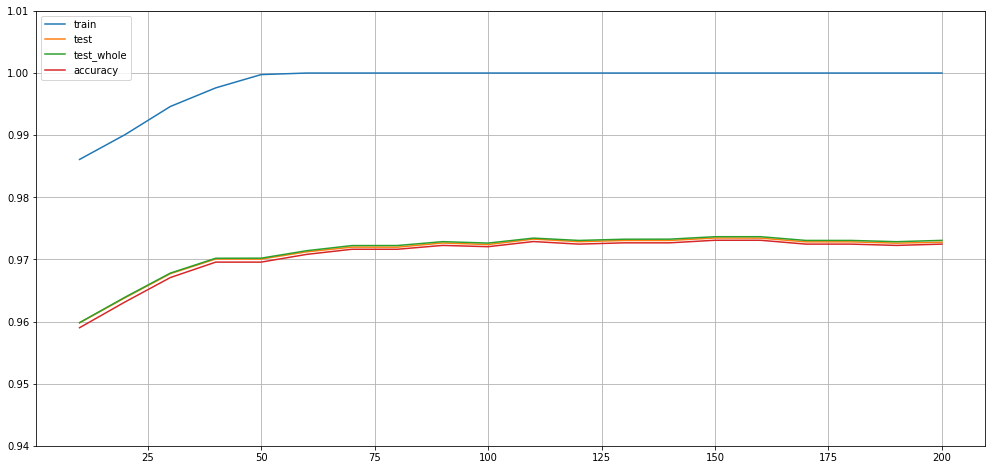

In [173]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                                  'reg_lambda':0.4, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.12, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9734538157777788
Wall time: 35min 18s


<AxesSubplot:>

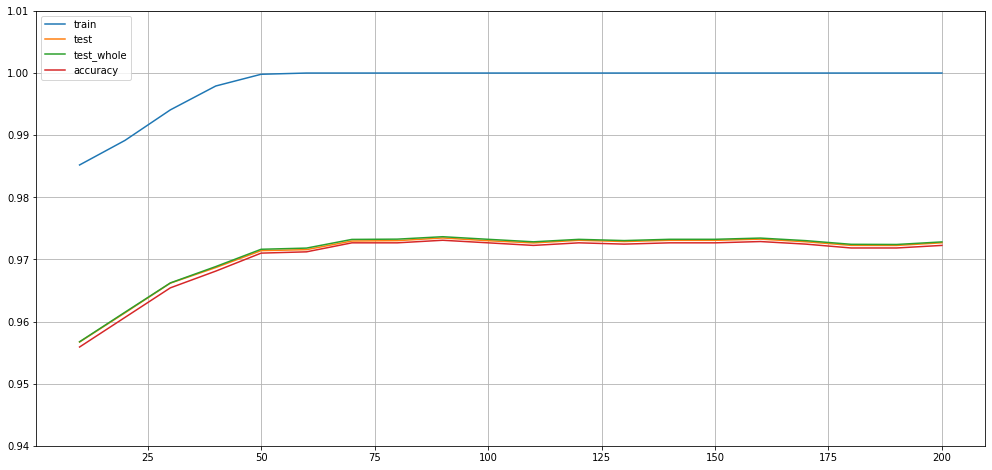

In [176]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                              'reg_lambda':0.4, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.12, 'random_state':10}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9730157039954836
Wall time: 36min 19s


<AxesSubplot:>

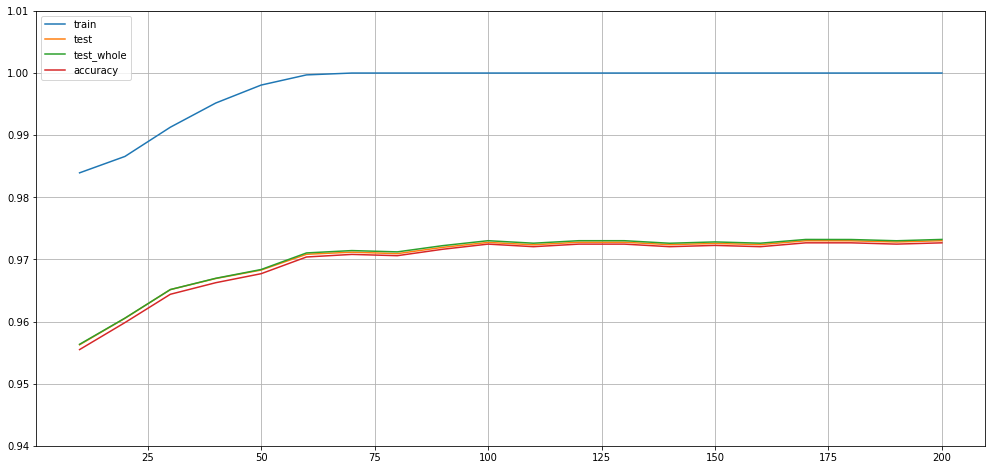

In [177]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.9, 'colsample_bynode':0.8,
                                   'num_parallel_tree':7, 'reg_lambda':0.4,
                                   'n_estimators':200, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9743448779810036
Wall time: 21min 52s


<AxesSubplot:>

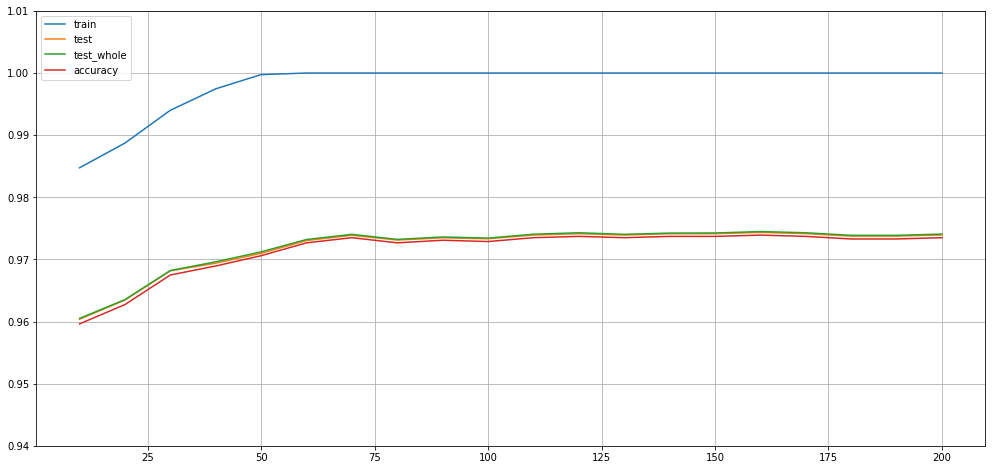

In [195]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                              'reg_lambda':0.4, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.12, 'random_state':10}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9742944850184481
Wall time: 29min 8s


<AxesSubplot:>

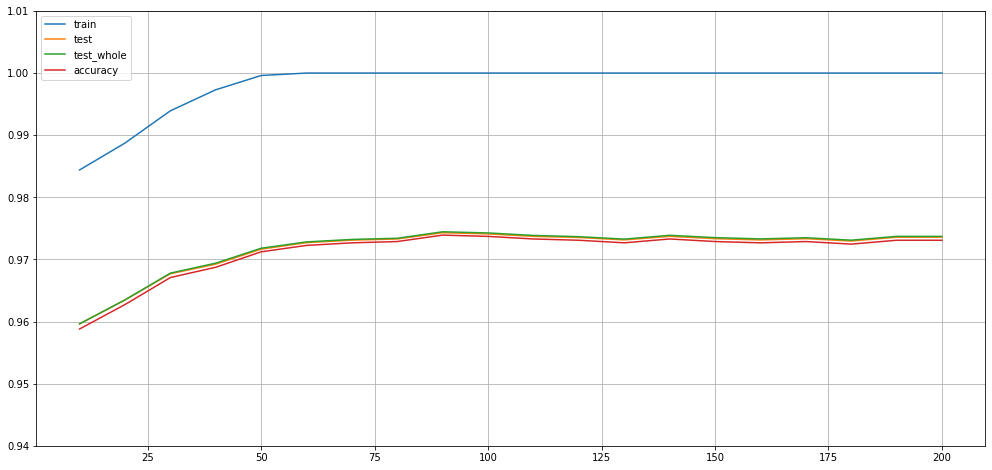

In [203]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                              'reg_lambda':0.4, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.12, 'random_state':10}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9744850105044496
Wall time: 53min 26s


<AxesSubplot:>

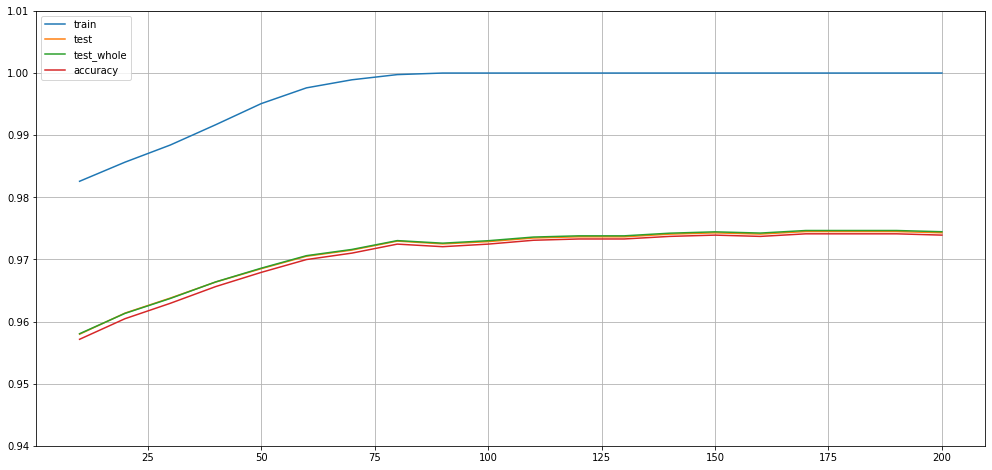

In [210]:
%%time
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.85, 'colsample_bynode':0.9,
                                   'num_parallel_tree':9, 'reg_lambda':0.3,
                                   'n_estimators':200, 'max_depth':7, 'learning_rate':0.08, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

In [10]:
res[-1]['max_score']

0.9726646748601493

0
1
2
3
4
0.9732150382813913


<AxesSubplot:>

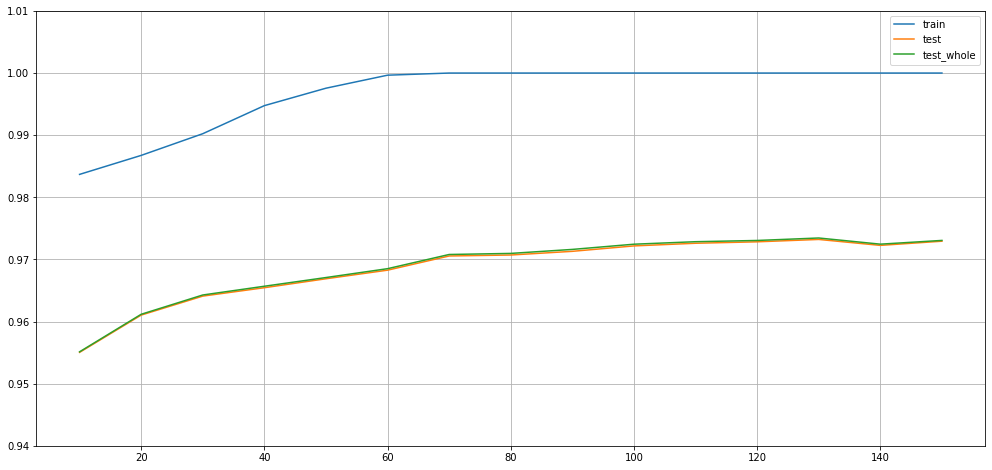

In [15]:
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                   'reg_lambda':0.4, 'n_estimators':150, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

0
1
2
3
4
0.9725759695730145


<AxesSubplot:>

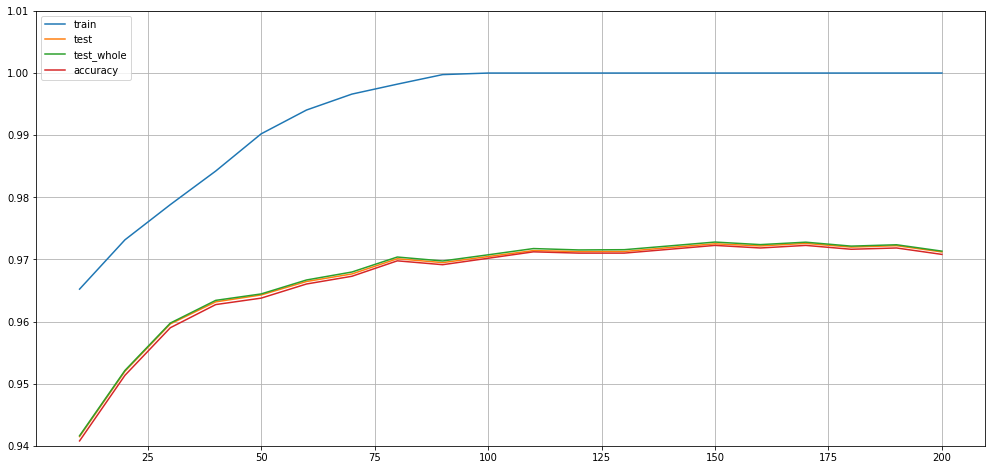

In [83]:
res.append(calc_crossval_pred(X,Y,{'objective':'multi:softproba', 'colsample_bytree':0.85, 'num_parallel_tree':6,
                                   'reg_lambda':0.3, 'n_estimators':200, 'max_depth':5, 'learning_rate':0.1, 'random_state':0}))

print(res[-1]['max_score'])
res[-1]['curve'].plot(figsize=(17,8),ylim=(0.94,1.01),grid='on')

In [97]:
res[-1]['curve'].reset_index()['test'].idxmax()

16

In [99]:
res[-1]['curve']['test'].iloc[16], res[-1]['max_score']

(0.9725759695730145, 0.9725759695730145)

In [95]:
def calc_recall_by_classes(y,p):
    PP = pd.DataFrame(y)
    PP.columns=['y']
    PP['p'] = p
    #return PP
    PP['eq'] = (PP['y']==PP['p']).astype(int)
    R = PP.groupby('y')[['eq']].sum()
    R['N'] = PP['y'].value_counts()
    R['M'] = PP['p'].value_counts()
    R['recall'] = R['eq']/R['N']
    print(R['recall'].mean())
    return R

def calc_crosstab(y,r):
    PP = pd.DataFrame(y)
    PP.columns = ['y']
    i = r['curve'].reset_index()['test'].idxmax()
    p = r['preds'][i]
    PP['p'] = p.astype(int)
    e = (PP['y']!=PP['p']).sum()
    print(e, 1-e/PP.shape[0],recall_score(y, p, average="macro", zero_division=0))
    return PP.value_counts().unstack().fillna(0).astype(int).join(calc_recall_by_classes(y,p).iloc[:,1:])

calc_crosstab(Y,res[-1])

134 0.9722567287784679 0.9727756021532487
0.9727756021532487


,0,1,2,3,4,5,6,N,M,recall
y,,,,,,,,,,
0,689,0,7,0,12,0,18,726,750,0.949036
1,2,697,0,0,1,0,0,700,698,0.995714
2,5,0,680,0,10,0,2,697,689,0.975610
3,0,0,0,655,0,0,0,655,656,1.000000
4,29,0,0,0,675,0,14,718,703,0.940111
5,0,0,1,1,0,666,0,668,666,0.997006
6,25,1,1,0,5,0,634,666,668,0.951952


In [96]:
res[-1]['curve']['test'].max()

0.9725759695730145

In [100]:
pred = res[-1]['preds'][16]
prob = res[-1]['probs'][16]

In [105]:
c2 = (Y==0)|(Y==6)
X2 = X[c2]
Y2 = Y[c2].map(lambda x: 0 if x==0 else 1)
c2.sum()

1392

In [101]:
(Y != pred).sum()

134

In [73]:
p_thr = 0.995
cc = (prob.max(axis=1)<p_thr)
X1 = X[cc]
Y1 = Y[cc]
cc.sum(), ((Y != pred)&(~cc)).sum()

(1407, 0)

In [37]:
p = prob[Y != pred].max(axis=1)
p.sort()
p, prob[Y == pred].max(axis=1).mean()

(array([0.34529218, 0.35415158, 0.39621758, 0.39757404, 0.40752086,
        0.41179639, 0.42127723, 0.42320335, 0.43821999, 0.43938005,
        0.44837281, 0.46421397, 0.46807551, 0.47971708, 0.48616415,
        0.48733169, 0.48775133, 0.50181371, 0.50254768, 0.50282741,
        0.50347656, 0.50797778, 0.51291794, 0.51524979, 0.51657534,
        0.5228554 , 0.52431387, 0.5269717 , 0.52755392, 0.52792633,
        0.53332287, 0.53429407, 0.53535593, 0.54648811, 0.54669178,
        0.56197667, 0.5706836 , 0.57522613, 0.58533466, 0.58950126,
        0.60236973, 0.60591567, 0.60596305, 0.61809194, 0.62060595,
        0.62160921, 0.62321115, 0.6254977 , 0.62673944, 0.63040334,
        0.6382609 , 0.6430077 , 0.64591074, 0.64624316, 0.64922249,
        0.65317965, 0.65457731, 0.65591347, 0.65751052, 0.66416669,
        0.6769374 , 0.68229616, 0.69653213, 0.70077592, 0.71429151,
        0.7195822 , 0.7227636 , 0.72918314, 0.73357284, 0.73433352,
        0.73519242, 0.73898232, 0.75099725, 0.76

0
1
2
3
4
0.8995068517250235 163.99999999999997


<AxesSubplot:>

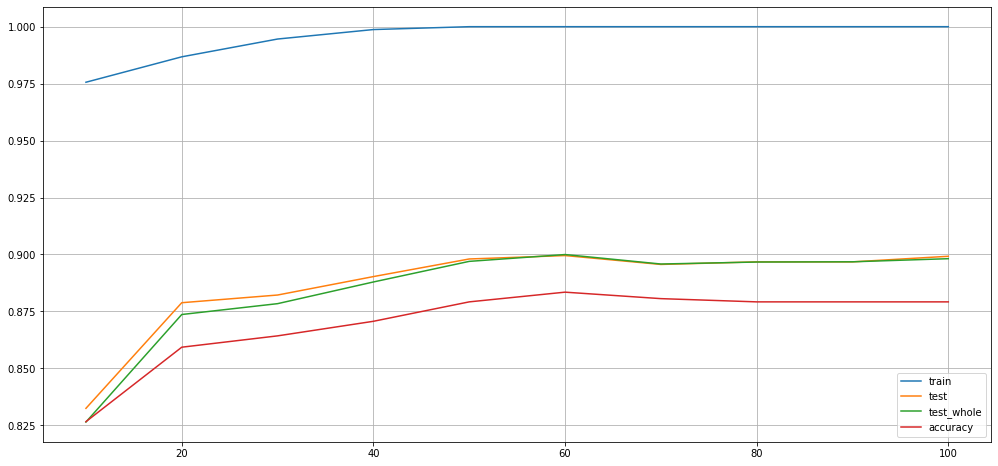

In [82]:
#res1 = []

res1.append(calc_crossval_pred(X1,Y1,{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                                'reg_lambda':0.4, 'n_estimators':100, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

res1[-1]['p_thr'] = p_thr
print(res1[-1]['max_score'],(1-res1[-1]['curve']['accuracy'].max())*Y1.shape[0])
res1[-1]['curve'].plot(figsize=(17,8),grid='on')

0
1
2
3
4
0.9609767369006967 54.00000000000007


<AxesSubplot:>

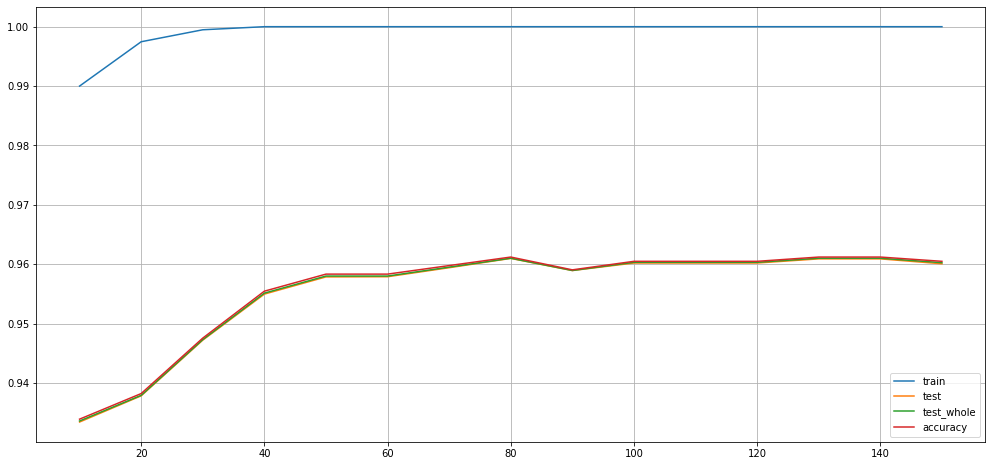

In [110]:
#res2 = []

res2.append(calc_crossval_pred(X2,Y2,{'objective':'binary:logistic', 'colsample_bytree':0.8, 'num_parallel_tree':4,
                                'reg_lambda':0.4, 'n_estimators':150, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}))

print(res2[-1]['max_score'],(1-res2[-1]['curve']['accuracy'].max())*Y2.shape[0])
res2[-1]['curve'].plot(figsize=(17,8),grid='on')

In [151]:
(Z<=0).sum(axis=1)

0       11
1        9
2       13
3        8
4        5
        ..
4825     6
4826     6
4827     8
4828     7
4829     6
Length: 4830, dtype: int64

In [138]:
#X0 = X.iloc[:,7:]
Z = X0
ZZ = Z[Z>=0.3]
#Z = Z[Z>=0.3].T.reset_index(drop=True).interpolate(limit_direction='both',method='cubic')
#Z = Z[Z>=0.3].T.interpolate(limit_direction='both')
X['mean'] = ZZ.median(axis=1)
X['std'] = ZZ.std(axis=1)
X['median'] = ZZ.median(axis=1)
X['mean_median'] = X['mean'] - X['median']
X['q70'] = ZZ.quantile(q=0.7,axis=1)
X['q80'] = ZZ.quantile(q=0.8,axis=1)
X['q90'] = ZZ.quantile(q=0.9,axis=1)
X['q90_median'] = X['q90'] - X['median']
X['max'] = ZZ.max(axis=1)

In [140]:
tt = [0, 20, 30, 40, 50, 60, 70]

for i in range(len(tt)-1):
    Zi = ZZ.iloc[:,tt[i]:tt[i+1]]
    n = tt[i+1]
    X['mean%i'%(n)] = Zi.median(axis=1)
    X['median%i'%(n)] = Zi.median(axis=1)
    X['q75_%i'%(n)] = Zi.quantile(q=0.75,axis=1)
    X['max%i'%(n)] = Zi.max(axis=1)
    
for i in range(len(tt)-2):
    n = tt[i+1]
    n2 = tt[i+2]
    X['d_mean%i'%(n)] = X['mean%i'%(n2)] - X['mean%i'%(n)]
    X['d_max%i'%(n)] = X['max%i'%(n2)] - X['max%i'%(n)]

X

,area,X,Y,XpY,XmY,c_len,c_type,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,...,d_mean20,d_max20,d_mean30,d_max30,d_mean40,d_max40,d_mean50,d_max50,d_mean60,d_max60
0,20,42.500303,51.412815,93.913118,-8.912513,36,1,0.187150,0.072846,0.262300,...,NaN,NaN,0.044162,-0.042108,0.048747,0.107797,0.223873,0.181534,-0.021848,0.023534
1,45,50.265608,56.606045,106.871653,-6.340437,134,1,0.245285,0.332928,0.349133,...,0.169440,0.343740,0.157962,0.015530,-0.000422,0.000159,0.008906,0.000476,-0.034220,-0.002811
2,28,38.003231,53.837187,91.840417,-15.833956,20,1,0.006391,0.013679,0.000000,...,0.055026,0.055026,0.021738,0.088524,0.134034,0.091106,-0.166108,-0.093065,-0.193909,-0.236938
3,19,44.727709,55.935536,100.663245,-11.207827,16,1,0.293425,0.105976,0.318047,...,0.201901,0.379416,0.120262,0.046191,-0.022420,-0.040357,-0.106905,-0.121723,-0.149888,-0.212008
4,33,34.783534,52.907252,87.690785,-18.123718,33,1,0.027983,0.130885,0.117227,...,NaN,NaN,NaN,NaN,NaN,NaN,0.173203,0.200741,0.016340,0.030469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,74,40.906039,50.899595,91.805634,-9.993556,52,1,0.066154,0.028770,0.000000,...,-0.071528,-0.035859,-0.043938,-0.079608,0.322293,0.337343,0.015414,0.100234,-0.056191,-0.100988
4826,109,40.013739,51.804439,91.818179,-11.790700,92,1,0.243867,0.035939,0.013403,...,0.232031,0.260549,-0.005630,-0.034148,0.234676,0.260045,-0.023811,0.040431,0.028260,-0.044450
4827,58,38.584332,53.193459,91.777791,-14.609127,46,1,0.090026,0.191255,0.019897,...,0.087477,0.078106,0.154792,0.126435,0.156815,0.190459,-0.068457,0.050178,0.048184,-0.061128
4828,14,53.319120,55.183574,108.502694,-1.864453,13,1,0.301663,0.291399,0.295089,...,0.235160,0.394517,0.088592,-0.075822,0.024409,0.121946,-0.004622,-0.072426,-0.151490,-0.166453


In [208]:
cols0 = ['area', 'X', 'Y', 'XpY', 'XmY', 'size', 'angle', 'c_len', 'c_type', 'ext', 'Xp2Y', 'Xm2Y']
cols1 = [v for v in df.columns.sort_values() if v[:2]=='nd']
cols = cols0 + cols1

def prepare_sample(df):
    X = df[cols].copy()
    
    Z = X[cols1]
    ZZ = Z[Z>=0.3]
    
    X['LE0'] = (Z<=0).sum(axis=1)
    X['LE03'] = (Z<=0.3).sum(axis=1)
    X['R03'] = (X['LE0'] + 0) / (X['LE03'] + 1)

    X['RR0'] = (Z.iloc[:,35:]<=0).sum(axis=1) / (X['LE0'] + 1)
    X['RR03'] = (Z.iloc[:,35:]<=0.3).sum(axis=1) / (X['LE03'] + 1)

    X['mean'] = ZZ.median(axis=1)
    X['std'] = ZZ.std(axis=1)
    X['median'] = ZZ.median(axis=1)
    X['mean_median'] = X['mean'] - X['median']
    X['q70'] = ZZ.quantile(q=0.7,axis=1)
    X['q80'] = ZZ.quantile(q=0.8,axis=1)
    X['q90'] = ZZ.quantile(q=0.9,axis=1)
    X['q90_median'] = X['q90'] - X['median']
    X['max'] = ZZ.max(axis=1)
    
    tt = [0, 35, 50, 70]

    for i in range(len(tt)-1):
        Zi = ZZ.iloc[:,tt[i]:tt[i+1]]
        n = tt[i+1]
        X['amean%i'%(n)] = Zi.mean(axis=1)
        X['amedian%i'%(n)] = Zi.median(axis=1)
        X['aq75_%i'%(n)] = Zi.quantile(q=0.75,axis=1)
        X['amax%i'%(n)] = Zi.max(axis=1)
        
        X['d_amean%i'%(n)] = X['amean%i'%(n)] - X['amedian%i'%(n)]
        X['d_amax%i'%(n)] = X['amax%i'%(n)] - X['amedian%i'%(n)]

    for i in range(len(tt)-2):
        n = tt[i+1]
        n2 = tt[i+2]
        X['ad_median%i'%(n)] = X['amedian%i'%(n2)] - X['amedian%i'%(n)]
#       X['ad_max%i'%(n)] = X['amax%i'%(n2)] - X['amax%i'%(n)]
        
    return X

X = prepare_sample(df)
X

,area,X,Y,XpY,XmY,size,angle,c_len,c_type,ext,...,d_amean50,d_amax50,amean70,amedian70,aq75_70,amax70,d_amean70,d_amax70,ad_median35,ad_median50
0,20,42.500303,51.412815,93.913118,-8.912513,0.021183,0.389150,36,1,2.243563,...,0.001235,0.073923,0.704191,0.714614,0.727918,0.754859,-0.010424,0.040245,0.078036,0.238746
1,45,50.265608,56.606045,106.871653,-6.340437,0.026451,0.675479,134,1,1.554754,...,-0.042448,0.036806,0.641722,0.666918,0.696734,0.709037,-0.025195,0.042120,0.170270,-0.004838
2,28,38.003231,53.837187,91.840417,-15.833956,0.016500,0.745071,20,1,0.972273,...,-0.015688,0.056449,0.492751,0.533167,0.559921,0.648106,-0.040416,0.114939,0.123180,-0.151555
3,19,44.727709,55.935536,100.663245,-11.207827,0.017946,0.769360,16,1,1.695082,...,0.018310,0.125270,0.452359,0.446105,0.536427,0.591204,0.006253,0.145099,0.103251,-0.181909
4,33,34.783534,52.907252,87.690785,-18.123718,0.018536,0.753283,33,1,1.041174,...,-0.023417,0.019064,0.734409,0.761576,0.777849,0.833694,-0.027167,0.072117,0.127243,0.178156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,74,40.906039,50.899595,91.805634,-9.993556,0.026831,0.891493,52,1,0.972877,...,-0.014388,0.015050,0.675732,0.685665,0.751970,0.801592,-0.009933,0.115927,0.278354,-0.000644
4826,109,40.013739,51.804439,91.818179,-11.790700,0.033023,0.944493,92,1,1.000468,...,0.002696,0.025369,0.766783,0.780407,0.799638,0.845264,-0.013624,0.064858,0.234676,0.000942
4827,58,38.584332,53.193459,91.777791,-14.609127,0.025016,0.814600,46,1,1.078984,...,0.005419,0.033644,0.685695,0.740523,0.781434,0.844618,-0.054828,0.104095,0.339964,-0.020273
4828,14,53.319120,55.183574,108.502694,-1.864453,0.019994,0.246009,13,1,2.855318,...,-0.025236,0.117452,0.563874,0.568314,0.691126,0.694709,-0.004440,0.126395,0.100444,-0.081368


In [159]:
%%time
bst = xgb.XGBClassifier(**{'objective':'multi:softproba', 'colsample_bytree':0.8, 'num_parallel_tree':5,
                          'reg_lambda':0.5, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.1, 'random_state':0}
                       ).fit(X,Y)

Wall time: 6min 36s


In [174]:
%%time
bst = xgb.XGBClassifier(**{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                                  'reg_lambda':0.4, 'n_estimators':200, 'max_depth':7, 'learning_rate':0.12, 'random_state':0}
                       ).fit(X,Y)

Wall time: 8min 33s


In [204]:
%%time
bst1 = xgb.XGBClassifier(**{'objective':'multi:softproba', 'colsample_bytree':0.75, 'num_parallel_tree':7,
                                  'reg_lambda':0.4, 'n_estimators':150, 'max_depth':7, 'learning_rate':0.12, 'random_state':10}
                       ).fit(X,Y)

Xt = prepare_sample(dft)

dft['Pred'] = bst1.predict(Xt[imp1.index])

Wall time: 4min 57s


In [215]:
%%time
bst1 = xgb.XGBClassifier(**{'objective':'multi:softproba', 'colsample_bytree':0.85, 'colsample_bynode':0.9,
                                   'num_parallel_tree':9, 'reg_lambda':0.3,
                                   'n_estimators':215, 'max_depth':7, 'learning_rate':0.08, 'random_state':10}
                       ).fit(X,Y)

Xt = prepare_sample(dft)

dft['Pred'] = bst1.predict(Xt[imp1.index])

Wall time: 10min


In [216]:
#Xt = prepare_sample(dft)

#dft['Pred'] = bst.predict(Xt)

df_sln = pd.read_csv("C:/work/Kaggle/agro/data/sample_solution.csv").set_index('id')
df_sln['crop'] = dft.set_index('id')['Pred'] 
df_sln.to_csv("C:/work/Kaggle/agro/sln_15.csv")
df_sln

,crop
id,
611,3
6417,2
3352,3
4224,1
3102,6
...,...
1743,5
3968,3
3809,2


In [187]:
imp = pd.DataFrame({t:bst.get_booster().get_score(importance_type=t) for t in['gain','weight','total_gain']}
            ).sort_values('total_gain')
imp.iloc[-60:]

,gain,weight,total_gain
amax35,1.319846,634.0,836.782288
c_len,1.087745,901.0,980.057861
nd_mean_2021-07-26,2.269746,441.0,1000.958069
nd_mean_2021-08-27,2.039629,507.0,1034.092163
nd_mean_2021-06-06,1.900850,553.0,1051.170166
nd_mean_2021-05-03,2.303571,462.0,1064.249756
nd_mean_2021-04-27,1.376511,856.0,1178.293457
ad_median50,3.886434,334.0,1298.068848
LE03,1.998177,682.0,1362.756470
nd_mean_2021-04-25,1.437449,1277.0,1835.622559


In [188]:
imp.iloc[:60]

,gain,weight,total_gain
median,0.284035,44.0,12.497537
LE0,0.441475,47.0,20.749327
R03,0.369621,126.0,46.572193
mean,0.420486,197.0,82.835663
amax70,0.474905,186.0,88.332336
RR0,0.385466,232.0,89.428017
aq75_50,0.945651,99.0,93.619461
amax50,0.610313,159.0,97.039726
nd_mean_2021-06-22,0.444695,227.0,100.945755
std,0.475892,215.0,102.316689


In [189]:
imp.sort_values('gain').iloc[:60]

,gain,weight,total_gain
median,0.284035,44.0,12.497537
R03,0.369621,126.0,46.572193
RR0,0.385466,232.0,89.428017
nd_mean_2021-05-09,0.388892,281.0,109.278786
size,0.393142,394.0,154.897781
nd_mean_2021-04-23,0.407416,381.0,155.225510
mean,0.420486,197.0,82.835663
nd_mean_2021-06-05,0.424426,435.0,184.625397
ext,0.424778,280.0,118.937950
LE0,0.441475,47.0,20.749327


In [190]:
imp.sort_values('weight').iloc[:60]

,gain,weight,total_gain
median,0.284035,44.0,12.497537
LE0,0.441475,47.0,20.749327
aq75_50,0.945651,99.0,93.619461
aq75_70,1.608313,100.0,160.831329
R03,0.369621,126.0,46.572193
amedian70,2.532690,140.0,354.576630
amedian50,0.853771,153.0,130.626892
amean70,0.866137,157.0,135.983475
amax50,0.610313,159.0,97.039726
q70,0.741543,168.0,124.579231


In [206]:
imp1 = imp.loc[(imp['gain']>=1)|(imp['weight']>=500)|(imp['total_gain']>=800)]
#imp1 = imp.loc[(imp['gain']>=1.5)|(imp['weight']>=550)|(imp['total_gain']>=900)]
imp1#.iloc[:60]

,gain,weight,total_gain
aq75_70,1.608313,100.0,160.831329
nd_mean_2021-04-20,1.067348,269.0,287.116547
nd_mean_2021-04-28,0.515049,607.0,312.634552
amedian35,1.218800,267.0,325.419525
amedian70,2.532690,140.0,354.576630
...,...,...,...
nd_mean_2021-05-26,23.068573,995.0,22953.230469
nd_mean_2021-08-01,11.553305,2040.0,23568.742188
nd_mean_2021-06-16,12.387590,2086.0,25840.513672
nd_mean_2021-05-15,14.811355,2086.0,30896.486328


In [209]:
X = X[imp1.index]

In [202]:
import pickle

with open('C:/work/Kaggle/agro/res.pkl','wb') as f:
    pickle.dump(res,f)